# Training a CNN + FNO on the 1D SWE 

### Initialize

In [1]:
save_plots = 1
save_results = 1
n_epochs_CNN = 500
n_epochs_FNO = 500

### Load packages

In [2]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.fftpack import fft, ifft
import scipy.io

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.models import SFNO
from neuralop import LpLoss, H1Loss

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

import time
import h5py
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\Matteo\AppData\Local\Temp\ipykernel_17336\871008888.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


cpu


### Functions

In [3]:
def prepare_data(h_all, p_train, p_val):
    # Fetch the dimensions of the input
    timesteps, _ = h_all.shape

    # Input a
    a = h_all[:-1]

    # Target u
    u = h_all[1:]

    # Split data into training, validation and test sets
    n_train = int(p_train * timesteps)
    n_val = int(p_val * timesteps)
    n_test = timesteps - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    # Define input and target training sets, validation sets and test sets
    train_x = torch.tensor(a[:n_train], dtype=torch.float32)
    train_y = torch.tensor(u[:n_train], dtype=torch.float32)

    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)

    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, a, u, timesteps, train_x, train_y, val_x, val_y, test_x, test_y

# Prepare data in sequences
def prepare_data_sequences(train_x, train_y, seq_length):
    # Fetch the dimensions of the input data
    timesteps, spatial_steps = train_x.shape[0], train_x.shape[1]

    # Number of sequences
    n_sequences = timesteps - seq_length

    # Prepare input and target sequences
    x_seq = torch.zeros((n_sequences, seq_length, spatial_steps))
    y_seq = torch.zeros((n_sequences, spatial_steps))

    for i in range(n_sequences):
        x_seq[i] = train_x[i:i + seq_length]
        y_seq[i] = train_y[i + seq_length]
    return x_seq, y_seq


### Plot initial condition

Key: data_0
  'data_0' is a group containing:
    h0
    h_all
    sigma
    time_all
    u_all
    x
'h_all' loaded with shape: (304, 100)
'u_all' loaded with shape: (304, 100)
'x' loaded with shape: (100,)
'time_all' loaded with shape: (304,)


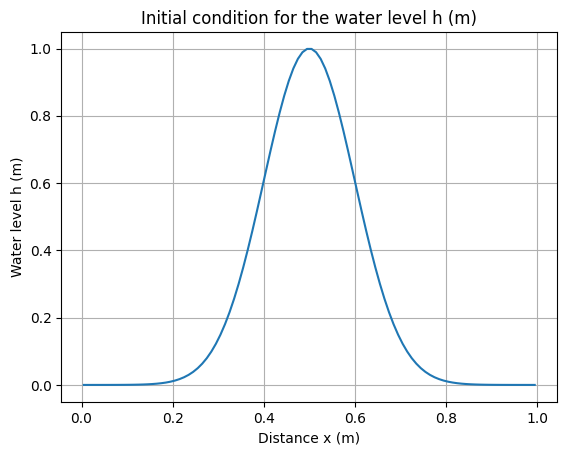

In [4]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\swe1d_data_gauss_middle.h5', 'r') as file:
    for key in file.keys():
        print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_all'][:-1])
    u_all = np.array(file['data_0']['u_all'][:-1])
    x = np.array(file['data_0']['x']).squeeze()
    time_all = np.array(file['data_0']['time_all']).squeeze()
    sigma = np.array(file['data_0']['sigma'])

    print(f"'h_all' loaded with shape: {h_all.shape}")
    print(f"'u_all' loaded with shape: {u_all.shape}")
    print(f"'x' loaded with shape: {x.shape}")
    print(f"'time_all' loaded with shape: {time_all.shape}")

# Plot the initial condition
plt.figure()
plt.plot(x.squeeze(), h_all[0,:])
plt.xlabel('Distance x (m)')
plt.ylabel('Water level h (m)')
plt.title('Initial condition for the water level h (m)')
plt.grid()

if save_plots:
    plt.savefig('plots/NN_initial_1D.pdf', format='pdf')
plt.show()

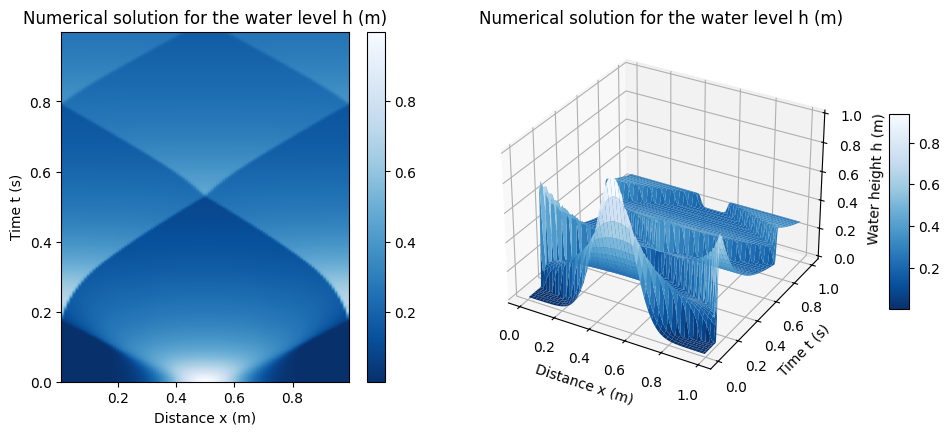

In [5]:
cmap = 'Blues_r'
X, T = np.meshgrid(x, time_all)

# Plot the data in x,t space
fig = plt.figure(figsize=(12, 5))

# Plot the initial condition
ax0 = fig.add_axes([0.05, 0.15, 0.3, 0.7])  # [left, bottom, width, height]
plt.imshow(h_all, aspect='auto', cmap=cmap, extent=[x[0], x[-1], time_all[-1], time_all[0]])
plt.colorbar(ax=ax0)
ax0.set_title('Numerical solution for the water level h (m)')
ax0.set_xlabel('Distance x (m)')
ax0.set_ylabel('Time t (s)')
ax0.invert_yaxis()

# Plot in 3D
#ax1 = fig.add_subplot(122, projection='3d')
ax1 = fig.add_axes([0.4, 0.1, 0.4, 0.78], projection='3d')  # [left, bottom, width, height]
surf1 = ax1.plot_surface(X, T, h_all, cmap=cmap)
ax1.set_title('Numerical solution for the water level h (m)')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Time t (s)')
ax1.set_zlabel('Water height h (m)')
fig.colorbar(surf1, ax=ax1, shrink = 0.5, aspect=10, pad = 0.1)

if save_plots:
    plt.savefig('plots/NN_initial.pdf', format='pdf')

plt.show()

## CNN

### Load data from h5 file

In [6]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\swe1d_data_gauss_middle.h5', 'r') as file:
    for key in file.keys():
        print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_all'][:-1])
    u_all = np.array(file['data_0']['u_all'][:-1])
    x = np.array(file['data_0']['x']).squeeze()
    time_all = np.array(file['data_0']['time_all']).squeeze()
    sigma = np.array(file['data_0']['sigma'])

    print(f"'h_all' loaded with shape: {h_all.shape}")
    print(f"'u_all' loaded with shape: {u_all.shape}")
    print(f"'x' loaded with shape: {x.shape}")
    print(f"'time_all' loaded with shape: {time_all.shape}")


Key: data_0
  'data_0' is a group containing:
    h0
    h_all
    sigma
    time_all
    u_all
    x
'h_all' loaded with shape: (304, 100)
'u_all' loaded with shape: (304, 100)
'x' loaded with shape: (100,)
'time_all' loaded with shape: (304,)


### Define model

In [7]:
# Define CNN-based model
class CNNFlowmap(nn.Module):
    def __init__(self, input_channels, hidden_size, output_size, num_filters = 64, kernel_size= 3):
        super(CNNFlowmap, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, num_filters, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size, padding=1)
        self.conv3 = nn.Conv1d(num_filters, num_filters, kernel_size, padding=1)
        self.final_conv = nn.Conv1d(num_filters, 1, kernel_size, padding=1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.final_conv(x)
        x = x.squeeze()
        x = F.relu(x)
        return x
    
input_size = 100
hidden_size = 64
output_size = 100
input_channels = 10 # seq_length

# Instantiate the model
model = CNNFlowmap(input_channels, hidden_size, output_size)
print(model)

CNNFlowmap(
  (conv1): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (final_conv): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=64, out_features=100, bias=True)
)


### Prepare data

In [8]:
## Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val

n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, p_train, p_val)
print("Training data:", train_x.shape, train_y.shape)
print("Validation data:", val_x.shape, val_y.shape)
print("Test data:", test_x.shape, test_y.shape)

# Prepare data in sequences
seq_len = 10

train_x_seq, train_y_seq = prepare_data_sequences(train_x, train_y, seq_len)
print("Training sequences:", train_x_seq.shape, train_y_seq.shape)

val_x_seq, val_y_seq = prepare_data_sequences(val_x, val_y, seq_len)
test_x_seq, test_y_seq = prepare_data_sequences(test_x, test_y, seq_len)

batch_size = 32

# Create the data loaders
train_dataset = torch.utils.data.TensorDataset(train_x_seq, train_y_seq)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_x_seq, val_y_seq)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


n_train = 182, n_val = 60, n_test = 62
Training data: torch.Size([182, 100]) torch.Size([182, 100])
Validation data: torch.Size([60, 100]) torch.Size([60, 100])
Test data: torch.Size([61, 100]) torch.Size([61, 100])
Training sequences: torch.Size([172, 10, 100]) torch.Size([172, 100])


In [9]:
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_train = []
loss_val = []

# Time training
start_time = time.time()

# Training loop
n_epochs = n_epochs_CNN
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Validation loss
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for batch_X_val, batch_Y_val in val_loader:
            val_predictions = model(batch_X_val)
            val_loss = loss_fn(val_predictions, batch_Y_val)
            epoch_val_loss += val_loss.item() * batch_X_val.size(0)

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}")

# Time training
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f}s")

Epoch 0/500, Training loss: 0.038315, Validation loss: 0.001442
Epoch 10/500, Training loss: 0.001054, Validation loss: 0.000313
Epoch 20/500, Training loss: 0.000393, Validation loss: 0.000118
Epoch 30/500, Training loss: 0.000276, Validation loss: 0.000131
Epoch 40/500, Training loss: 0.000178, Validation loss: 0.000075
Epoch 50/500, Training loss: 0.000113, Validation loss: 0.000056
Epoch 60/500, Training loss: 0.000077, Validation loss: 0.000063
Epoch 70/500, Training loss: 0.000058, Validation loss: 0.000037
Epoch 80/500, Training loss: 0.000042, Validation loss: 0.000027
Epoch 90/500, Training loss: 0.000032, Validation loss: 0.000025
Epoch 100/500, Training loss: 0.000024, Validation loss: 0.000032
Epoch 110/500, Training loss: 0.000025, Validation loss: 0.000035
Epoch 120/500, Training loss: 0.000019, Validation loss: 0.000034
Epoch 130/500, Training loss: 0.000015, Validation loss: 0.000024
Epoch 140/500, Training loss: 0.000014, Validation loss: 0.000021
Epoch 150/500, Traini

In [10]:
# Save the training time
# Specify folder path (create the folder if it doesn't exist)
folder_path = 'C:/Users/Matteo/Shallow-Water-Equations/saved_results'
os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save the training time
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_time.txt')
    with open(file_path, 'w') as f:
        f.write(f"{training_time:.2f}") # Save with 2 decimals

    # Save n_epochs
    file_path = os.path.join(folder_path, f'1D_CNN_nepochs.txt')
    with open(file_path, 'w') as f:
        f.write(f"{n_epochs_CNN}") 

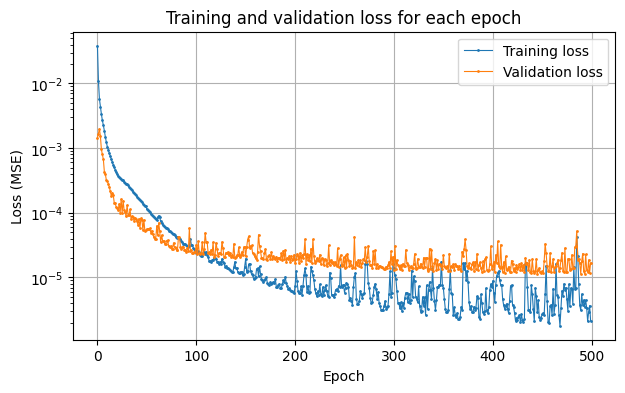

In [11]:
filename = 'plots/1D_CNN_loss.pdf'
plot_losses(loss_train, loss_val, save_plots, filename)

### Make predictions

In [12]:
# Make predictions
model.eval()
with torch.no_grad():
    pred_train = model(train_x_seq).cpu().detach().numpy()
    pred_val = model(val_x_seq).cpu().detach().numpy()
    pred_test = model(test_x_seq).cpu().detach().numpy()

# Combine the sequences
pred_all = np.concatenate((pred_train, pred_val, pred_test), axis=0)
print(pred_all.shape)

# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), train_y_seq).item()
val_loss = loss_fn(torch.tensor(pred_val), val_y_seq).item()
test_loss = loss_fn(torch.tensor(pred_test), test_y_seq).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")


(273, 100)
Train loss: 2.70e-06
Validation loss: 1.69e-05
Test loss: 2.25e-05


In [13]:
X_all, Y_all = prepare_data_sequences(torch.tensor(a, dtype=torch.float32), torch.tensor(u, dtype=torch.float32), seq_len)

# Make predictions
model.eval()
with torch.no_grad():
    pred_all = model(X_all).cpu().detach().numpy()
    overall_loss = loss_fn(torch.tensor(pred_all), Y_all).item()
    print(f"Overall loss: {overall_loss:.2e}")

# Save the test loss MSE
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_MSE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

Overall loss: 1.39e-05


In [14]:
# Calculate MAE
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), train_y_seq).item()
val_loss = loss_new(torch.tensor(pred_val), val_y_seq).item()
test_loss = loss_new(torch.tensor(pred_test), test_y_seq).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MAE
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_MAE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

Train loss: 1.17e-03
Validation loss: 2.94e-03
Test loss: 3.30e-03


### Plot predictions

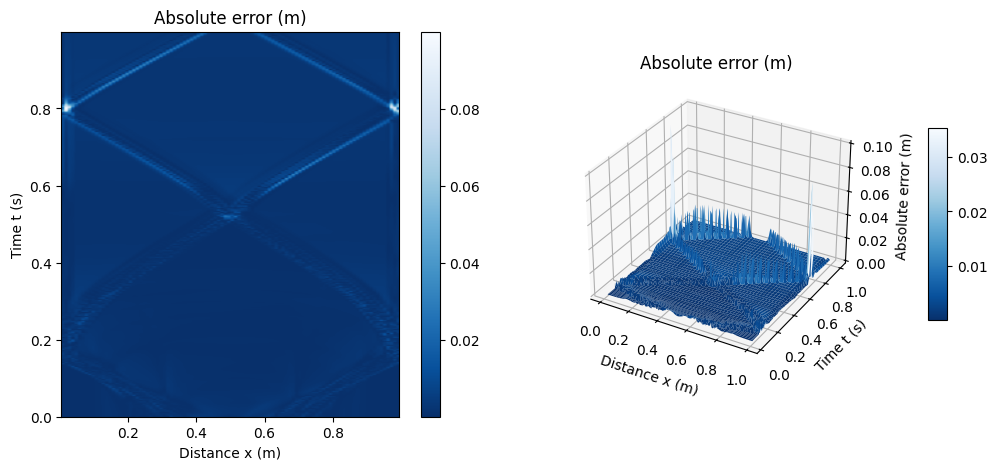

In [15]:
def plot_error(x, t_all, pred_all, u, save, filename):
    # Prepare grid
    X, T = np.meshgrid(x, t_all)
    cmap = 'Blues_r'

    fig = plt.figure(figsize=(12, 5))
    ax0 = fig.add_subplot(121)
    #ax0 = fig.add_axes([0.05, 0.15, 0.3, 0.7])  # [left, bottom, width, height]
    plt.imshow(np.abs(pred_all-u), aspect='auto', cmap=cmap, extent=[x[0], x[-1], time_all[-1], time_all[0]])
    plt.colorbar(ax=ax0)
    ax0.set_title('Absolute error (m)')
    ax0.set_xlabel('Distance x (m)')
    ax0.set_ylabel('Time t (s)')
    ax0.invert_yaxis()

    ax1 = fig.add_subplot(122, projection='3d')
    #ax1 = fig.add_axes([0.4, 0.1, 0.4, 0.85], projection='3d')  # [left, bottom, width, height]
    surf = ax1.plot_surface(X, T, np.abs(pred_all-u), cmap=cmap)
    ax1.set_title('Absolute error (m)')
    ax1.set_xlabel('Distance x (m)')
    ax1.set_ylabel('Time t (s)')
    ax1.set_zlabel('Absolute error (m)')
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, pad=0.15)  # Colorbar for 3D plot

    if save:
        plt.savefig(filename)

    plt.show()

plot_error(x, time_all[seq_len+1:], pred_all, u[seq_len:], save_plots, 'plots/1D_CNN_error.pdf')

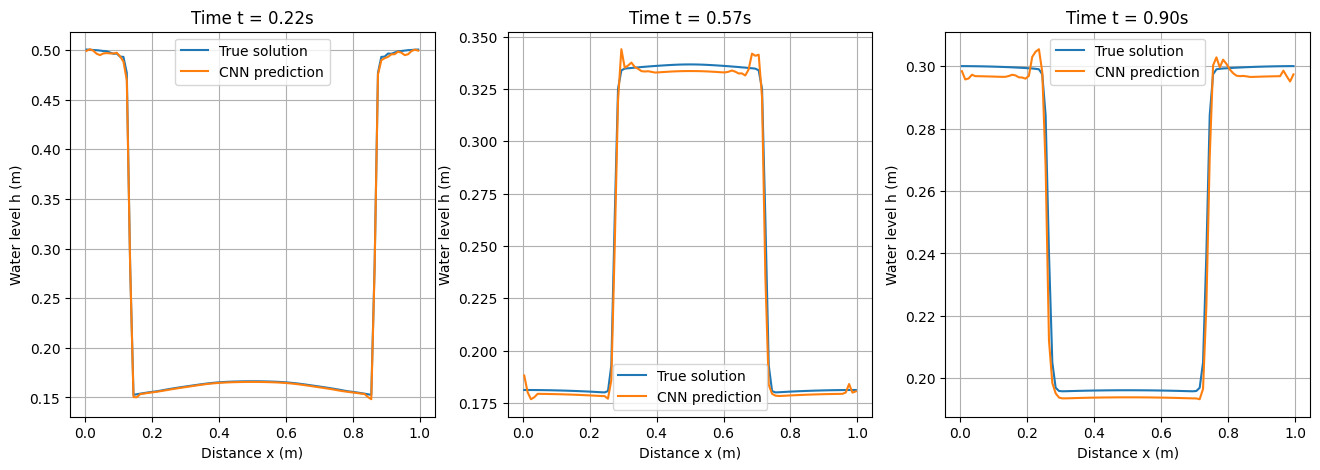

In [16]:
# Plot for some given time steps
indices = [100, 200, 280]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.plot(x, u[idx], label='True solution')
    ax.plot(x, pred_all[idx-seq_len], label='CNN prediction')
    ax.set_xlabel('Distance x (m)')
    ax.set_ylabel('Water level h (m)')
    ax.set_title(f'Time t = {time_all[idx]:.2f}s')
    ax.legend()
    ax.grid()

if save_plots:
    plt.savefig('plots/1D_CNN_pred_timesteps.pdf', format='pdf')

plt.show()


# FNO

### Load data from h5 file

In [60]:
# Load data
with h5py.File(r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\swe1d_data_gauss_middle.h5', 'r') as file:
    for key in file.keys():
        print(f"Key: {key}")
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_all'][:-1])
    u_all = np.array(file['data_0']['u_all'][:-1])
    x = np.array(file['data_0']['x']).squeeze()
    time_all = np.array(file['data_0']['time_all']).squeeze()
    sigma = np.array(file['data_0']['sigma'])

    print(f"'h_all' loaded with shape: {h_all.shape}")
    print(f"'u_all' loaded with shape: {u_all.shape}")
    print(f"'x' loaded with shape: {x.shape}")
    print(f"'time_all' loaded with shape: {time_all.shape}")


Key: data_0
  'data_0' is a group containing:
    h0
    h_all
    sigma
    time_all
    u_all
    x
'h_all' loaded with shape: (304, 100)
'u_all' loaded with shape: (304, 100)
'x' loaded with shape: (100,)
'time_all' loaded with shape: (304,)


### Define model

In [61]:
# Define FNO-based model
model = TFNO(
    n_modes=(24,), 
    in_channels=1,
    lifting_channels=32,  # 64
    hidden_channels=32, 
    projection_channels=32, 
    out_channels=1, 
    non_linearity=torch.functional.F.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')

batch_size = 16


The model has 109441 parameters.


### Prepare data

In [62]:
def prepare_data_FNO(h_all, p_train, p_val):
    # Fetch the dimensions of the input
    timesteps, _ = h_all.shape

    # Input a
    a = h_all[:-1]
    a = a[:, np.newaxis, :] # Add channel dimension

    # Target u (shifted by one time step)
    u = h_all[1:]
    u = u[:, np.newaxis, :] # Add channel dimension

    # Split data into training, validation and test sets
    n_train = int(p_train * timesteps)
    n_val = int(p_val * timesteps)
    n_test = timesteps - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    # Define input and target training sets, validation sets and test sets
    train_x = torch.tensor(a[:n_train], dtype=torch.float32)
    train_y = torch.tensor(u[:n_train], dtype=torch.float32)

    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)

    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, a, u, timesteps, train_x, train_y, val_x, val_y, test_x, test_y

In [63]:
# Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val

n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_FNO(h_all, p_train, p_val)

# Create the data loaders
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

n_train = 182, n_val = 60, n_test = 62


### Train model

In [64]:
loss_train = []
loss_val = []

model.to(device)

# Time training
start_time = time.time()

# Training loop
n_epochs = n_epochs_FNO
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0  # Track loss for the epoch

    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0)

    # Validation loss
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for batch_X_val, batch_Y_val in val_loader:
            val_predictions = model(batch_X_val)
            val_loss = loss_fn(val_predictions, batch_Y_val)
            epoch_val_loss += val_loss.item() * batch_X_val.size(0)

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}")

# Time training
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f}s")


Epoch 0/500, Training loss: 0.031744, Validation loss: 0.003591
Epoch 10/500, Training loss: 0.000366, Validation loss: 0.000084
Epoch 20/500, Training loss: 0.000316, Validation loss: 0.000068
Epoch 30/500, Training loss: 0.000237, Validation loss: 0.000065
Epoch 40/500, Training loss: 0.000151, Validation loss: 0.000066
Epoch 50/500, Training loss: 0.000124, Validation loss: 0.000061
Epoch 60/500, Training loss: 0.000092, Validation loss: 0.000060
Epoch 70/500, Training loss: 0.000074, Validation loss: 0.000053
Epoch 80/500, Training loss: 0.000058, Validation loss: 0.000037
Epoch 90/500, Training loss: 0.000097, Validation loss: 0.000044
Epoch 100/500, Training loss: 0.000037, Validation loss: 0.000032
Epoch 110/500, Training loss: 0.000035, Validation loss: 0.000032
Epoch 120/500, Training loss: 0.000043, Validation loss: 0.000029
Epoch 130/500, Training loss: 0.000028, Validation loss: 0.000025
Epoch 140/500, Training loss: 0.000026, Validation loss: 0.000027
Epoch 150/500, Traini

In [65]:
# Save the training time
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_time.txt')
    with open(file_path, 'w') as f:
        f.write(f"{training_time:.2f}") # Save with 2 decimals

    # Save n_epochs
    file_path = os.path.join(folder_path, f'1D_FNO_nepochs.txt')
    with open(file_path, 'w') as f:
        f.write(f"{n_epochs_FNO}") 

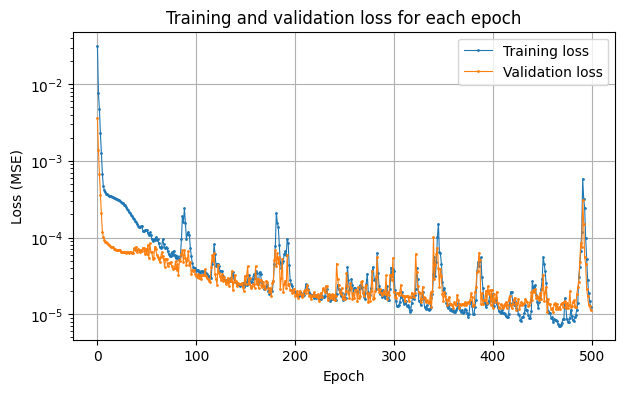

In [66]:
filename = 'plots/1D_FNO_loss.pdf'
plot_losses(loss_train, loss_val, save_plots, filename)

### Make predictions

In [67]:
# Make predictions
model.eval()
with torch.no_grad():
    pred_train = model(train_x).cpu().detach().numpy()
    pred_val = model(val_x).cpu().detach().numpy()
    pred_test = model(test_x).cpu().detach().numpy()

# Combine the sequences
pred_all = np.concatenate((pred_train, pred_val, pred_test), axis=0)
print(pred_all.shape)

# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), train_y).item()
val_loss = loss_fn(torch.tensor(pred_val), val_y).item()
test_loss = loss_fn(torch.tensor(pred_test), test_y).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MSE
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_MSE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

(303, 1, 100)
Train loss: 1.19e-05
Validation loss: 1.12e-05
Test loss: 1.04e-05


In [68]:
# Calculate MAE
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), train_y).item()
val_loss = loss_new(torch.tensor(pred_val), val_y).item()
test_loss = loss_new(torch.tensor(pred_test), test_y).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MAE
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_MAE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

Train loss: 2.05e-03
Validation loss: 2.04e-03
Test loss: 2.10e-03


### Plot predctions

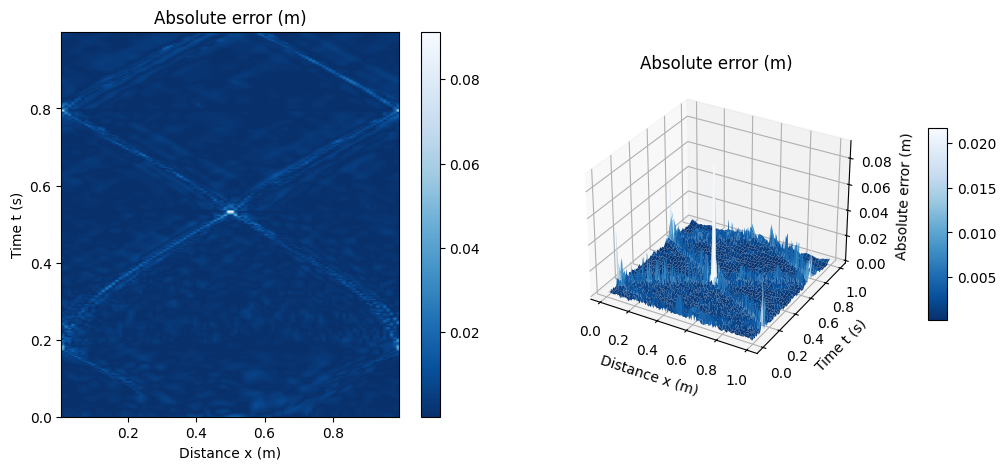

In [69]:
plot_error(x, time_all[1:], pred_all.squeeze(), u.squeeze(), save_plots, 'plots/1D_FNO_error.pdf')

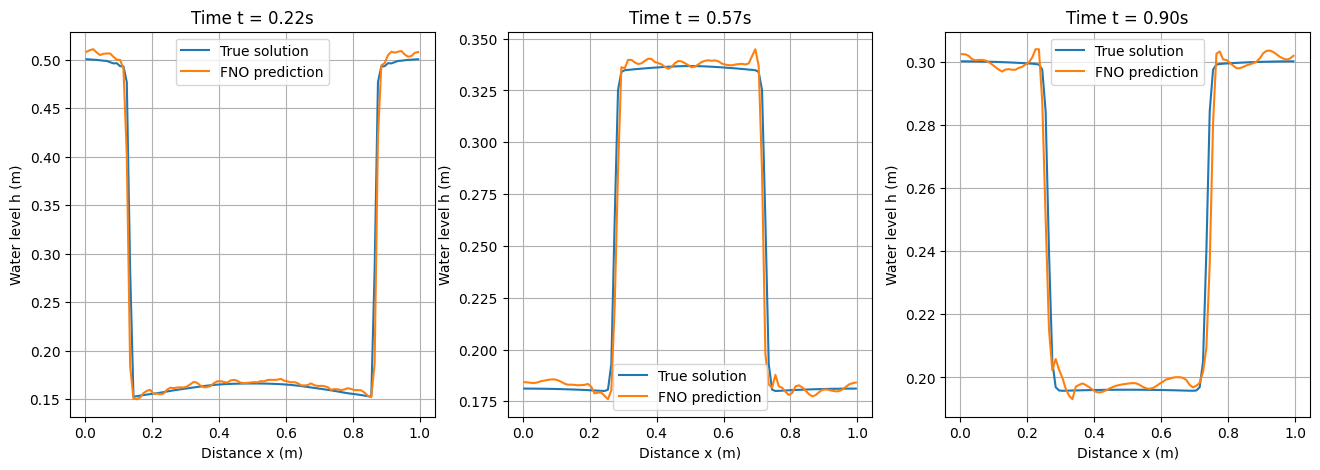

In [70]:
# Plot for some given time steps
indices = [100, 200, 280]

pred_all = pred_all.squeeze()
u = u.squeeze()

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.plot(x, u[idx], label='True solution')
    ax.plot(x, pred_all[idx-1], label='FNO prediction')
    ax.set_xlabel('Distance x (m)')
    ax.set_ylabel('Water level h (m)')
    ax.set_title(f'Time t = {time_all[idx]:.2f}s')
    ax.legend()
    ax.grid()

if save_plots:
    plt.savefig('plots/1D_FNO_pred_timesteps.pdf', format='pdf')

plt.show()